In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Necessary Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/AIML/mnist_dataset.csv")
print("Dataset Preview:")
print(df.head())
print("\nDataset Information:")
print(df.info())

Dataset Preview:
   label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0      5        0        0        0        0        0        0        0   
1      0        0        0        0        0        0        0        0   
2      4        0        0        0        0        0        0        0   
3      1        0        0        0        0        0        0        0   
4      9        0        0        0        0        0        0        0   

   pixel_7  pixel_8  ...  pixel_774  pixel_775  pixel_776  pixel_777  \
0        0        0  ...          0          0          0          0   
1        0        0  ...          0          0          0          0   
2        0        0  ...          0          0          0          0   
3        0        0  ...          0          0          0          0   
4        0        0  ...          0          0          0          0   

   pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  
0          0          0      

##  **Some Helper Function:**

### Softmax Function:

In [5]:
import numpy as np

def softmax(z):
    """
    Compute the softmax probabilities for a given input matrix.

    Parameters:
    z (numpy.ndarray): Logits (raw scores) of shape (m, n), where
                       - m is the number of samples.
                       - n is the number of classes.

    Returns:
    numpy.ndarray: Softmax probability matrix of shape (m, n), where
                   each row sums to 1 and represents the probability
                   distribution over classes.

    Notes:
    - The input to softmax is typically computed as: z = XW + b.
    - Uses numerical stabilization by subtracting the max value per row.
    """

    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    softmax_probs = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return softmax_probs

### Softmax Test Case:

This test case checks that each row in the resulting softmax probabilities sums to 1, which is the fundamental property of softmax.

In [6]:

z_test = np.array([[2.0, 1.0, 0.1], [1.0, 1.0, 1.0]])
softmax_output = softmax(z_test)
row_sums = np.sum(softmax_output, axis=1)
assert np.allclose(row_sums, 1), f"Test failed: Row sums are {row_sums}"

print("Softmax function passed the test case!")

Softmax function passed the test case!


### Prediction Function:

In [7]:
def predict_softmax(X, W, b):
    """
    Predict the class labels for a set of samples using the trained softmax model.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    W (numpy.ndarray): Weight matrix of shape (d, c), where c is the number of classes.
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    numpy.ndarray: Predicted class labels of shape (n,), where each value is the index of the predicted class.
    """
    logits = np.dot(X, W) + b

    probabilities = softmax(logits)
    predicted_classes = np.argmax(probabilities, axis=1)

    return predicted_classes

### Test Function for Prediction Function:
The test function ensures that the predicted class labels have the same number of elements as the input samples, verifying that the model produces a valid output shape.

In [8]:

X_test = np.array([[0.2, 0.8], [0.5, 0.5], [0.9, 0.1]])  # Feature matrix (3 samples, 2 features)
W_test = np.array([[0.4, 0.2, 0.1], [0.3, 0.7, 0.5]])  # Weights (2 features, 3 classes)
b_test = np.array([0.1, 0.2, 0.3])  # Bias (3 classes)

# Expected Output:
# The function should return an array with class labels (0, 1, or 2)

y_pred_test = predict_softmax(X_test, W_test, b_test)

# Validate output shape
assert y_pred_test.shape == (3,), f"Test failed: Expected shape (3,), got {y_pred_test.shape}"

# Print the predicted labels
print("Predicted class labels:", y_pred_test)

Predicted class labels: [1 1 0]


### Loss Function:

In [9]:
def loss_softmax(y_pred, y):
    """
    Compute the cross-entropy loss for a single sample.

    Parameters:
    y_pred (numpy.ndarray): Predicted probabilities of shape (c,) for a single sample,
                             where c is the number of classes.
    y (numpy.ndarray): True labels (one-hot encoded) of shape (c,), where c is the number of classes.

    Returns:
    float: Cross-entropy loss for the given sample.
    """
    # Avoid log(0) by adding a small epsilon (1e-12) to y_pred
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    loss = -np.sum(y * np.log(y_pred))

    return loss

## Test case for Loss Function:
This test case Compares loss for correct vs. incorrect predictions.
*   Expects low loss for correct predictions.
*   Expects high loss for incorrect predictions.

In [10]:
import numpy as np
y_true_correct = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
y_pred_correct = np.array([[0.9, 0.05, 0.05],
                           [0.1, 0.85, 0.05],
                           [0.05, 0.1, 0.85]])

# Define incorrect predictions (high loss scenario)
y_pred_incorrect = np.array([[0.05, 0.05, 0.9],
                              [0.1, 0.05, 0.85],
                              [0.85, 0.1, 0.05]])

# Compute loss for both cases
loss_correct = loss_softmax(y_pred_correct, y_true_correct)
loss_incorrect = loss_softmax(y_pred_incorrect, y_true_correct)

# Validate that incorrect predictions lead to a higher loss
assert loss_correct < loss_incorrect, f"Test failed: Expected loss_correct < loss_incorrect, but got {loss_correct:.4f} >= {loss_incorrect:.4f}"

# Print results
print(f"Cross-Entropy Loss (Correct Predictions): {loss_correct:.4f}")
print(f"Cross-Entropy Loss (Incorrect Predictions): {loss_incorrect:.4f}")

Cross-Entropy Loss (Correct Predictions): 0.4304
Cross-Entropy Loss (Incorrect Predictions): 8.9872


### Cost Function:

In [11]:
def cost_softmax(X, y, W, b):
    """
    Compute the average softmax regression cost (cross-entropy loss) over all samples.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c), where n is the number of samples and c is the number of classes.
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    float: Average softmax cost (cross-entropy loss) over all samples.
    """
    n = X.shape[0]  # Number of samples

    # Compute logits: XW + b
    logits = np.dot(X, W) + b  # Shape: (n, c)

    # Apply softmax to get probabilities
    probabilities = softmax(logits)  # Shape: (n, c)

    # Clip probabilities to avoid log(0)
    epsilon = 1e-12
    probabilities = np.clip(probabilities, epsilon, 1 - epsilon)

    # Compute cross-entropy loss for each sample
    losses = -np.sum(y * np.log(probabilities), axis=1)  # Shape: (n,)

    # Compute total loss
    total_loss = np.sum(losses)

    # Return average loss
    return total_loss / n

### Test Case for Cost Function:
The test case assures that the cost for the incorrect prediction should be higher than for the correct prediction, confirming that the cost function behaves as expected.

In [12]:
import numpy as np

# Example 1: Correct Prediction (Closer predictions)
X_correct = np.array([[1.0, 0.0], [0.0, 1.0]])  # Feature matrix for correct predictions
y_correct = np.array([[1, 0], [0, 1]])  # True labels (one-hot encoded, matching predictions)
W_correct = np.array([[5.0, -2.0], [-3.0, 5.0]])  # Weights for correct prediction
b_correct = np.array([0.1, 0.1])  # Bias for correct prediction

# Example 2: Incorrect Prediction (Far off predictions)
X_incorrect = np.array([[0.1, 0.9], [0.8, 0.2]])  # Feature matrix for incorrect predictions
y_incorrect = np.array([[1, 0], [0, 1]])  # True labels (one-hot encoded, incorrect predictions)
W_incorrect = np.array([[0.1, 2.0], [1.5, 0.3]])  # Weights for incorrect prediction
b_incorrect = np.array([0.5, 0.6])  # Bias for incorrect prediction

# Compute cost for correct predictions
cost_correct = cost_softmax(X_correct, y_correct, W_correct, b_correct)

# Compute cost for incorrect predictions
cost_incorrect = cost_softmax(X_incorrect, y_incorrect, W_incorrect, b_incorrect)

# Check if the cost for incorrect predictions is greater than for correct predictions
assert cost_incorrect > cost_correct, f"Test failed: Incorrect cost {cost_incorrect} is not greater than correct cost {cost_correct}"

# Print the costs for verification
print("Cost for correct prediction:", cost_correct)
print("Cost for incorrect prediction:", cost_incorrect)

print("Test passed!")


Cost for correct prediction: 0.0006234364133349324
Cost for incorrect prediction: 0.29930861359446115
Test passed!


### Computing Gradients:

In [13]:
import numpy as np

def compute_gradient_softmax(X, y, W, b):
    """
    Compute the gradients of the cost function with respect to weights and biases.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    tuple: Gradients with respect to weights (d, c) and biases (c,).
    """

    # Compute logits: XW + b
    logits = np.dot(X, W) + b

    # Apply softmax to get probabilities
    y_pred = softmax(logits)

    # Compute the error term (difference between predicted and true labels)
    error = y_pred - y

    # Compute the gradient with respect to weights
    grad_W = np.dot(X.T, error) / X.shape[0]  # Average over all samples (n, c)

    # Compute the gradient with respect to biases
    grad_b = np.sum(error, axis=0) / X.shape[0]  # Average over all samples (c,)

    return grad_W, grad_b


### Test case for compute_gradient function:
The test checks if the gradients from the function are close enough to the manually computed gradients using np.allclose, which accounts for potential floating-point discrepancies.

In [14]:
import numpy as np

# Define a simple feature matrix and true labels
X_test = np.array([[0.2, 0.8], [0.5, 0.5], [0.9, 0.1]])  # Feature matrix (3 samples, 2 features)
y_test = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # True labels (one-hot encoded, 3 classes)

# Define weight matrix and bias vector
W_test = np.array([[0.4, 0.2, 0.1], [0.3, 0.7, 0.5]])  # Weights (2 features, 3 classes)
b_test = np.array([0.1, 0.2, 0.3])  # Bias (3 classes)

# Compute the gradients using the function
grad_W, grad_b = compute_gradient_softmax(X_test, y_test, W_test, b_test)

# Manually compute the predicted probabilities (using softmax function)
z_test = np.dot(X_test, W_test) + b_test
y_pred_test = softmax(z_test)

# Compute the manually computed gradients
grad_W_manual = np.dot(X_test.T, (y_pred_test - y_test)) / X_test.shape[0]
grad_b_manual = np.sum(y_pred_test - y_test, axis=0) / X_test.shape[0]

# Assert that the gradients computed by the function match the manually computed gradients
assert np.allclose(grad_W, grad_W_manual), f"Test failed: Gradients w.r.t. W are not equal.\nExpected: {grad_W_manual}\nGot: {grad_W}"
assert np.allclose(grad_b, grad_b_manual), f"Test failed: Gradients w.r.t. b are not equal.\nExpected: {grad_b_manual}\nGot: {grad_b}"

# Print the gradients for verification
print("Gradient w.r.t. W:", grad_W)
print("Gradient w.r.t. b:", grad_b)

print("Test passed!")


Gradient w.r.t. W: [[ 0.1031051   0.01805685 -0.12116196]
 [-0.13600547  0.00679023  0.12921524]]
Gradient w.r.t. b: [-0.03290036  0.02484708  0.00805328]
Test passed!


### Implementing Gradient Descent:

In [15]:
def gradient_descent_softmax(X, y, W, b, alpha, n_iter, show_cost=False):
    """
    Perform gradient descent to optimize the weights and biases.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
    alpha (float): Learning rate.
    n_iter (int): Number of iterations.
    show_cost (bool): Whether to display the cost at intervals.

    Returns:
    tuple: Optimized weights, biases, and cost history.
    """
    cost_history = []

    for i in range(n_iter):
        # Compute gradients
        grad_W, grad_b = compute_gradient_softmax(X, y, W, b)

        # Update weights and biases using gradient descent
        W -= alpha * grad_W
        b -= alpha * grad_b

        # Compute the cost and add to cost history
        cost = cost_softmax(X, y, W, b)
        cost_history.append(cost)

        # Optionally display cost at intervals
        if show_cost and i % 10 == 0:
            print(f"Iteration {i}, Cost: {cost:.4f}")

    return W, b, cost_history


## Preparing Dataset:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_and_prepare_mnist(csv_file, test_size=0.2, random_state=42):
    """
    Reads the MNIST CSV file, splits data into train/test sets, and plots one image per class.

    Arguments:
    csv_file (str)       : Path to the CSV file containing MNIST data.
    test_size (float)    : Proportion of the data to use as the test set (default: 0.2).
    random_state (int)   : Random seed for reproducibility (default: 42).

    Returns:
    X_train, X_test, y_train, y_test : Split dataset.
    """

    # Load dataset
    df = pd.read_csv(csv_file)

    # Separate labels and features
    y = df.iloc[:, 0].values  # First column is the label
    X = df.iloc[:, 1:].values  # Remaining columns are pixel values

    # Normalize pixel values (optional but recommended)
    X = X / 255.0  # Scale values between 0 and 1

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Plot one sample image per class
    plot_sample_images(X, y)

    return X_train, X_test, y_train, y_test

def plot_sample_images(X, y):
    """
    Plots one sample image for each digit class (0-9).

    Arguments:
    X (np.ndarray): Feature matrix containing pixel values.
    y (np.ndarray): Labels corresponding to images.
    """

    plt.figure(figsize=(10, 4))
    unique_classes = np.unique(y)  # Get unique class labels

    for i, digit in enumerate(unique_classes):
        index = np.where(y == digit)[0][0]  # Find first occurrence of the class
        image = X[index].reshape(28, 28)  # Reshape 1D array to 28x28

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Digit: {digit}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


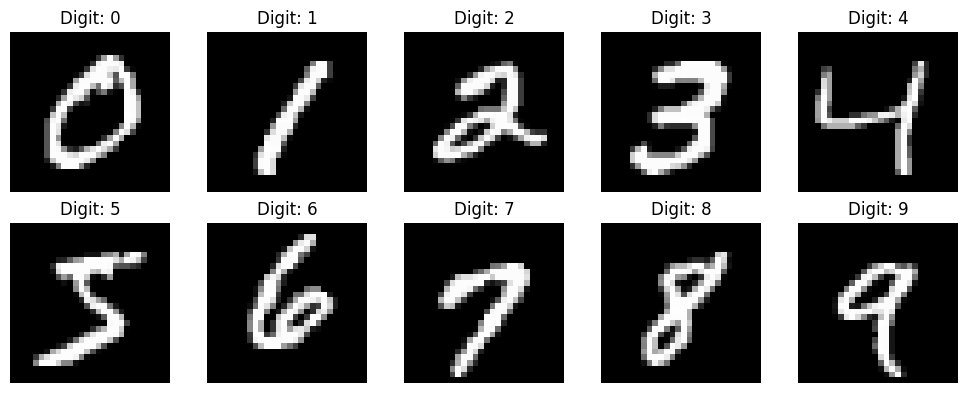

In [17]:
csv_file_path = "/content/drive/MyDrive/AIML/mnist_dataset.csv"  # Path to saved dataset
X_train, X_test, y_train, y_test = load_and_prepare_mnist(csv_file_path)

### **A Quick debugging Step:**

In [18]:
# Assert that X and y have matching lengths
assert len(X_train) == len(y_train), f"Error: X and y have different lengths! X={len(X_train)}, y={len(y_train)}"
print("Move forward: Dimension of Feture Matrix X and label vector y matched.")

Move forward: Dimension of Feture Matrix X and label vector y matched.


## **Train the Model:**

In [19]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (48000, 784)
Test data shape: (12000, 784)


Iteration 0, Cost: 2.1914
Iteration 10, Cost: 1.4932
Iteration 20, Cost: 1.1583
Iteration 30, Cost: 0.9768
Iteration 40, Cost: 0.8646
Iteration 50, Cost: 0.7883
Iteration 60, Cost: 0.7327
Iteration 70, Cost: 0.6903
Iteration 80, Cost: 0.6567
Iteration 90, Cost: 0.6293
Iteration 100, Cost: 0.6065
Iteration 110, Cost: 0.5871
Iteration 120, Cost: 0.5704
Iteration 130, Cost: 0.5559
Iteration 140, Cost: 0.5431
Iteration 150, Cost: 0.5317
Iteration 160, Cost: 0.5215
Iteration 170, Cost: 0.5122
Iteration 180, Cost: 0.5039
Iteration 190, Cost: 0.4962
Iteration 200, Cost: 0.4892
Iteration 210, Cost: 0.4827
Iteration 220, Cost: 0.4767
Iteration 230, Cost: 0.4711
Iteration 240, Cost: 0.4659
Iteration 250, Cost: 0.4611
Iteration 260, Cost: 0.4565
Iteration 270, Cost: 0.4522
Iteration 280, Cost: 0.4482
Iteration 290, Cost: 0.4443
Iteration 300, Cost: 0.4407
Iteration 310, Cost: 0.4373
Iteration 320, Cost: 0.4340
Iteration 330, Cost: 0.4309
Iteration 340, Cost: 0.4280
Iteration 350, Cost: 0.4251
Ite

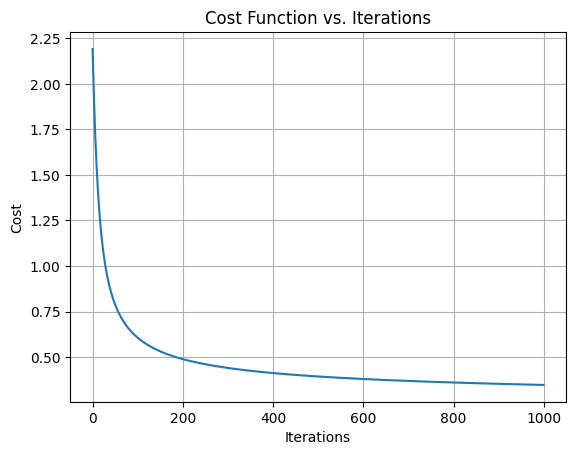

In [20]:
from sklearn.preprocessing import OneHotEncoder

# Check if y_train is one-hot encoded
if len(y_train.shape) == 1:
    encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output=False for newer versions of sklearn
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))  # One-hot encode labels
    y_test = encoder.transform(y_test.reshape(-1, 1))  # One-hot encode test labels

# Now y_train is one-hot encoded, and we can proceed to use it
d = X_train.shape[1]  # Number of features (columns in X_train)
c = y_train.shape[1]  # Number of classes (columns in y_train after one-hot encoding)

# Initialize weights with small random values and biases with zeros
W = np.random.randn(d, c) * 0.01  # Small random weights initialized
b = np.zeros(c)  # Bias initialized to 0

# Set hyperparameters for gradient descent
alpha = 0.1  # Learning rate
n_iter = 1000  # Number of iterations to run gradient descent

# Train the model using gradient descent
W_opt, b_opt, cost_history = gradient_descent_softmax(X_train, y_train, W, b, alpha, n_iter, show_cost=True)

# Plot the cost history to visualize the convergence
plt.plot(cost_history)
plt.title('Cost Function vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)
plt.show()


## **Evaluating the Model:**

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Evaluation Function
def evaluate_classification(y_true, y_pred):
    """
    Evaluate classification performance using confusion matrix, precision, recall, and F1-score.

    Parameters:
    y_true (numpy.ndarray): True labels
    y_pred (numpy.ndarray): Predicted labels

    Returns:
    tuple: Confusion matrix, precision, recall, F1 score
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return cm, precision, recall, f1



Confusion Matrix:
[[1127    0    5    2    3   12    9    2   12    3]
 [   0 1275    7   11    1    5    1    4   17    1]
 [   2   15 1028   17   19    3   27   25   32    6]
 [   8    5   34 1051    1   53    9    8   29   21]
 [   1    5    7    1 1093    0   10    4    4   51]
 [  22   14   13   44   12  922   14    7   42   14]
 [   7    2    9    1   11   15 1120    2   10    0]
 [   7   26   26    5   16    2    0 1181    7   29]
 [   9   27   16   35    9   30   12    6 1001   15]
 [   8    6   10   18   43    9    0   38   10 1052]]
Precision: 0.90
Recall: 0.90
F1-Score: 0.90


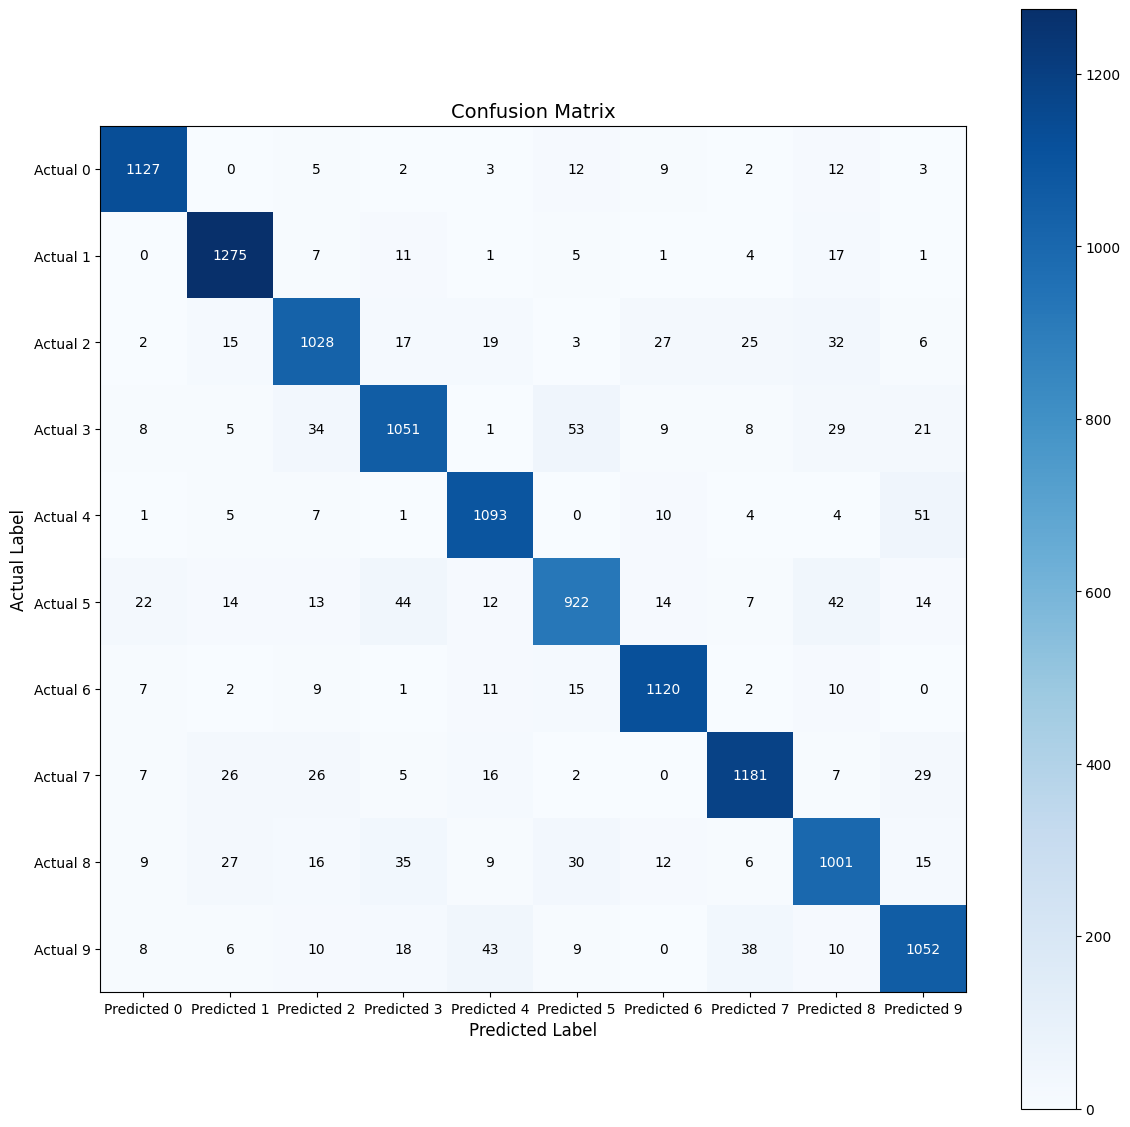

In [22]:
# Predict on the test set
y_pred_test = predict_softmax(X_test, W_opt, b_opt)

# Evaluate accuracy
y_test_labels = np.argmax(y_test, axis=1)  # True labels in numeric form

# Evaluate the model
cm, precision, recall, f1 = evaluate_classification(y_test_labels, y_pred_test)

# Print the evaluation metrics
print("\nConfusion Matrix:")
print(cm)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Visualizing the Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(cm, cmap='Blues')  # Use a color map for better visualization

# Dynamic number of classes
num_classes = cm.shape[0]
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels([f'Predicted {i}' for i in range(num_classes)])
ax.set_yticklabels([f'Actual {i}' for i in range(num_classes)])

# Add labels to each cell in the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > np.max(cm) / 2 else 'black')

# Add grid lines and axis labels
ax.grid(False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.colorbar(cax)
plt.show()


# Linear Seperability and Logistic Regression:

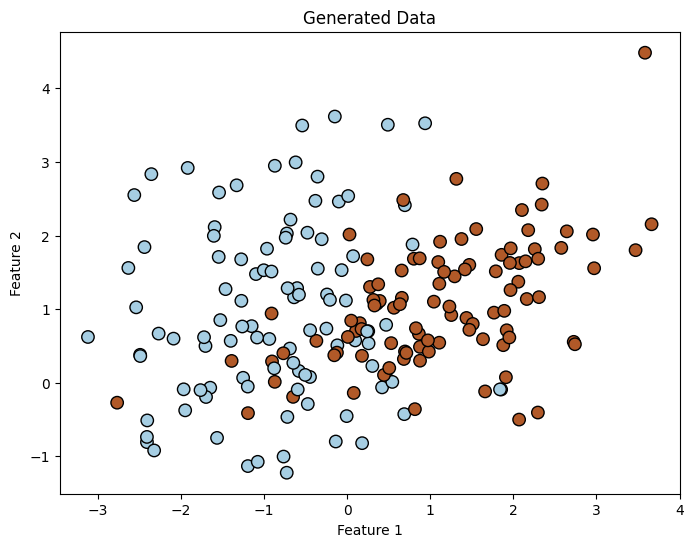

Accuracy: 0.8750


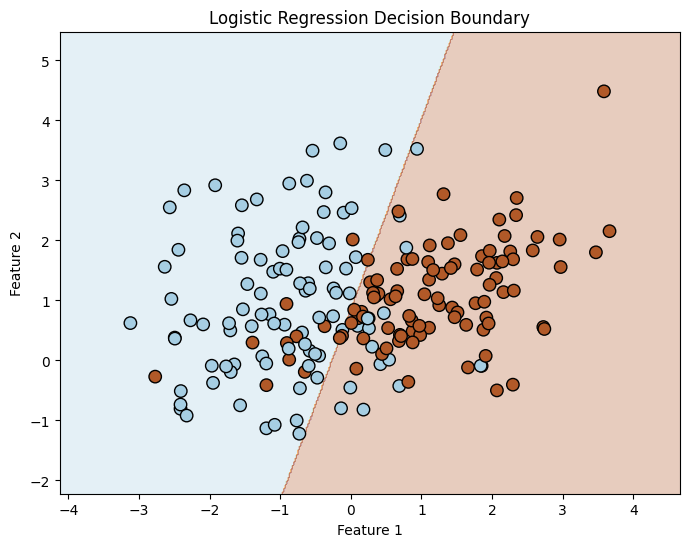

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def generate_data(linearly_separable=True, n_samples=200):
    X, y = make_classification(n_samples=n_samples, n_features=2, n_classes=2,
                               n_redundant=0, n_clusters_per_class=1, random_state=42)
    if not linearly_separable:
        X, y = make_classification(n_samples=n_samples, n_features=2, n_classes=2,
                                   n_redundant=0, n_clusters_per_class=2, random_state=42)
    return X, y

def plot_data(X, y, title="Data Distribution"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k", s=80)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

def train_logistic_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return model

def plot_decision_boundary(X, y, model):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired, s=80)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary")
    plt.show()

# Execute Steps
X, y = generate_data(linearly_separable=True)
plot_data(X, y, "Generated Data")

model = train_logistic_regression(X, y)
plot_decision_boundary(X, y, model)
